# Logistic Regression

In [2]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [5]:
def preprocess_features(california_housing_dataframe):
    """
    Prepare input features from CA housing data set
    Args:
        california_housing_dataframe: 'DataFrame' holding CA housing data
    Returns:
        A 'DataFrame' containing features to be used by the model
    """
    
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    
    processed_features = selected_features.copy()
    # create synthetic feature
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] / 
        california_housing_dataframe["population"])
    return processed_features

In [6]:
def preprocess_targets(california_housing_dataframe):
    """
    Prepare target features from CA housing data set
    Args:
        california_housing_dataframe: 'DataFrame' holding CA housing data
    Returns:
        A 'DataFrame' containing target feature to be used by the model
    """
    targets = pd.DataFrame()
    targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return targets

## Split data into training/validation sets



In [12]:
# training data top 12000
training_examples = preprocess_features(california_housing_dataframe).head(12000)
training_targets = preprocess_targets(california_housing_dataframe).head(12000)

In [13]:
# validation data bottom 5000
validation_examples = preprocess_features(california_housing_dataframe).tail(5000)
validation_targets = preprocess_targets(california_housing_dataframe).tail(5000)

In [14]:
# check data splits
print("Training example summary")
display.display(training_examples.describe())
print("Validation example summary")
display.display(validation_examples.describe())
print("Training targets summary")
display.display(training_targets.describe())
print("Validation targets summary")
display.display(validation_targets.describe())

Training example summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2630.7,536.6,1424.8,499.0,3.9,2.0
std,2.1,2.0,12.5,2166.3,419.9,1144.8,383.7,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,296.0,788.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2123.0,431.0,1162.0,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3141.0,646.0,1717.0,600.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation example summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2674.9,546.0,1441.0,506.6,3.9,2.0
std,2.1,2.0,12.7,2212.2,425.4,1155.1,386.4,1.9,1.0
min,32.5,-124.3,2.0,11.0,3.0,3.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1470.0,298.0,792.0,284.0,2.6,1.5
50%,34.2,-118.5,29.0,2143.0,441.0,1179.5,417.0,3.5,1.9
75%,37.7,-118.0,37.0,3179.8,655.2,1735.5,614.0,4.7,2.3
max,41.8,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,41.3


Training targets summary


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [15]:
def construct_feature_columns(input_features):
    """
    Construct TensorFlow feature columns
    Args:
        input_features: Names of numerical input features to use
    Returns:
        Set of feature columns
    """
    return set([tf.feature_column.numeric_column(feature) for feature in input_features])

In [17]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Trains a linear regression model
    
    Args:
        features: A 'DataFrame' of features
        targets: A 'DataFrame' of targets
        batch_size: A nonzero 'int' to pass to model
        shuffle: A 'boolean' to shuffle data or not
        num_epochs: A nonzero 'int' for which data should be repeated
    Returns:
        A tuple of features,labels for next data batch
    """
    # convert dataframe into dict with np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # construct dataset
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle if needed
    if shuffle:
        ds.shuffle(10000)
        
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels

In [24]:
def train_linear_regresor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """
    Trains a linear regression model.
    Prints training progress, and plots training/validation loss over time
    
    Args:
        learning_rate: A 'float', the learning rate
        steps: A non-zero 'int', the number of training steps
        batch_size: A non-zero 'int', the batch size
        training_examples: A 'DataFrame' containing input features for training from CA housing data
        training_targets: A 'DataFrame' containing the target feature for training from CA housing data
        validation_examples: A 'DataFrame' containing input features for validation from CA housing data
        validation_targets: A 'DataFrame' containing the target feature for validation from CA housing data
    """
    
    periods = 10
    steps_per_period = steps / periods
    target_col = "median_house_value_is_high"
    
    # create linear regressor
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
    
    # create input functions
    training_input_fn = lambda: my_input_fn(
        features=training_examples, targets=training_targets[target_col], batch_size=batch_size)
    predictions_training_input_fn = lambda: my_input_fn(
        features=training_examples, targets=training_targets[target_col], shuffle=False, num_epochs=1)
    predictions_validation_input_fn = lambda: my_input_fn(
        features=validation_examples, targets=validation_targets[target_col], shuffle=False, num_epochs=1)
    
    # train model
    print("Training model...")
    print("RMSE (training):")
    training_rmse = []
    validation_rmse = []
    for period in range(0,periods):
        linear_regressor.train(training_input_fn, steps=steps)
        
        # make predictions for reporting progress
        train_predictions = linear_regressor.predict(predictions_training_input_fn)
        train_predictions = np.array([item['predictions'][0] for item in train_predictions])
        
        validation_predictions = linear_regressor.predict(predictions_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # compute rmse
        train_rmse = math.sqrt(metrics.mean_squared_error(training_targets, train_predictions))
        valid_rmse = math.sqrt(metrics.mean_squared_error(validation_targets, validation_predictions))
        
        print("     %02d : %0.2f" % (period, train_rmse))
        training_rmse.append(train_rmse)
        validation_rmse.append(valid_rmse)
    print("Model training finished")
    
    # output graph of loss metrics
    plt.ylabel("RMSE")
    plt.xlabel("Period")
    plt.title("RMSE vs Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

Training model...
RMSE (training):
     00 : 0.44
     01 : 0.44
     02 : 0.44
     03 : 0.44
     04 : 0.44
     05 : 0.43
     06 : 0.43
     07 : 0.43
     08 : 0.43
     09 : 0.43
Model training finished


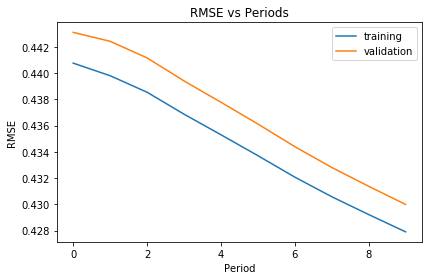

In [25]:
train_linear_regresor_model(
    learning_rate=.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)